In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
receiver_stat_cols = [
	"dense_depth",
	"receptions_roll",
	"targets_roll",
	"receiving_yards_roll",
	"receiving_tds_roll",
	"receiving_air_yards_roll",
	"receiving_yards_after_catch_roll",
	"receiving_first_downs_roll",
	"target_share_roll",
	"air_yards_share_roll",
	"fantasy_points_ppr_roll",
	'yards_per_target_roll',
	'yards_per_catch_roll',
]

team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
]
opp_stat_cols = [
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	"wind",
	#"temp",
	'spread_line',
	'total_line',
]

x_cols = game_context_cols + [
    'is_first_down',
	"dense_depth",
	"receptions_roll",
	"targets_roll",
	"receiving_yards_roll",
	"receiving_tds_roll",
	"receiving_air_yards_roll",
	"receiving_yards_after_catch_roll",
	"receiving_first_downs_roll",
	"target_share_roll",
	"air_yards_share_roll",
	"fantasy_points_ppr_roll",
	'yards_per_target_roll',
	'yards_per_catch_roll',
] + ['passing_yards_opp_roll']

In [3]:
passes = Quack.query(f"""
select pbp.game_id, pbp.air_yards,
	case when pbp.air_yards >= pbp.yardline_100 then 1 else 0 end as air_td,
	case when pbp.air_yards >= pbp.ydstogo then 1 else 0 end as air_fd,
	greatest(least(pbp.air_yards + 40, 139),1) as air_yards_shifted,
	pbp.yards_after_catch as yac,
	greatest(least(pbp.yards_after_catch + 40, 139),1) as yac_shifted,
	case when ydstogo = 10  then 1 else 0 end as is_first_down,
	pbp.first_down, pbp.touchdown,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	{Quack.select_columns(receiver_stat_cols, alias='r', coalesce=True)},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.receiver_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.pass = 1
	and pbp.pass_attempt = 1
	and pbp.down is not null
	and pbp.play_type = 'pass'
""")

X = passes[x_cols]
y = passes['air_yards_shifted']
Xyac = passes[x_cols + ['air_yards']]
yyac = passes['yac_shifted']
obs = len(X)
num_feats = len(x_cols)
y.shape

(213046,)

In [4]:
x_cols

['yardline_100',
 'ydstogo',
 'down',
 'goal_to_go',
 'wind',
 'spread_line',
 'total_line',
 'is_first_down',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'receiving_air_yards_roll',
 'receiving_yards_after_catch_roll',
 'receiving_first_downs_roll',
 'target_share_roll',
 'air_yards_share_roll',
 'fantasy_points_ppr_roll',
 'yards_per_target_roll',
 'yards_per_catch_roll',
 'passing_yards_opp_roll']

In [5]:
print(y.min(),y.max())

1.0 139.0


In [6]:
passes['air_td'].value_counts(normalize=True).reset_index().sort_values(by='air_td').head(20)

,air_td,proportion
0,0,0.932451
1,1,0.067549


In [7]:
def train_model(X, y, n_in, n_out,n_hidden=64, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.25, k=5)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	criterion = FocalLossSoft(gamma=4)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.004)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 10  # 10% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices]
	Xtst = X[test_indices]
	train_y = y[train_indices]
	train_y_smooth = smoothed_y[train_indices]
	test_y =  y[test_indices]
	test_y_smooth = smoothed_y[test_indices]
	train_is_td = (train_y == (40 +  Xtr[:,0])).float()
	train_is_fd = (train_y >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop
	try:
		for epoch in range(epochs):
			model.train()
			permutation = torch.randperm(Xtr.size(0))
			epoch_mean_loss = 0
			epoch_class_loss = 0
			yard_idx = torch.arange(n_out, device=device).unsqueeze(0)

			for i in range(0, Xtr.size(0), batch_size):
				batch_idx = permutation[i:i + batch_size]
				batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
				batch_y_smooth =  train_y_smooth[batch_idx]
				batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

				optimizer.zero_grad()
				outputs = model(batch_x)  # Shape: [batch_size, n_out]
				probs = torch.softmax(outputs, dim=1)

				fd_mask = yard_idx >= (batch_x[:,1] + 40).unsqueeze(1) # [9, 140]
				fd_output = (probs * fd_mask).sum(1).clamp(0, 1)
				td_mask = yard_idx >= (batch_x[:,0] + 40).unsqueeze(1)  # [9, 140]
				td_output = (probs * td_mask).sum(1).clamp(0, 1)
				td_loss = td_criterion(td_output, batch_td) * 0.5
				fd_loss = fd_criterion(fd_output, batch_fd) * 0.5


				probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
				classifier_loss = criterion(outputs, batch_y_smooth) * 6
				mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 2.25
				loss = classifier_loss + mean_loss + td_loss + fd_loss
				#loss = classifier_loss + td_loss
				loss.backward()
				optimizer.step()

				epoch_mean_loss += mean_loss.item()
				epoch_class_loss += classifier_loss.item()
			n_batches = len(range(0, Xtr.size(0), batch_size))
			print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


			model.eval()
			with torch.no_grad():
				test_preds = model(Xtst)
				test_loss = criterion(test_preds, test_y).item() 
				accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
			print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	except Exception as e:
		print(fd_output.max(), fd_output.min())
		raise e
	return model

In [8]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

air_yards_model = train_model(X_tensor, y_tensor, num_feats, 140, n_hidden=512, epochs = 20, batch_size=2048) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')
#Test Loss: 3.6856, Test Accuracy: 0.0827
#Test Loss: 3.3504, Test Accuracy: 0.1119
#Epoch 20/20, Classifier Loss: 28.4379, MSE Loss: 38.0815
#Test Loss: 2.7789, Test Accuracy: 0.1603
#Epoch 20/20, Classifier Loss: 20.7130, MSE Loss: 75.9770 focal loss soft
#Test Loss: 3.0928, Test Accuracy: 0.1557
#Epoch 20/20, Classifier Loss: 20.7351, MSE Loss: 75.9967 #512 layers, less lr and weight decay
#Test Loss: 2.9591, Test Accuracy: 0.1546

cuda
tensors loading
splitting batches
tensor(0.4391, device='cuda:0')
tensor(0.0676, device='cuda:0')
Epoch 1/20, Classifier Loss: 132.5497, MSE Loss: 227.7877
Test Loss: 93885.3906, Test Accuracy: 0.0721
Epoch 2/20, Classifier Loss: 55.2545, MSE Loss: 190.9540
Test Loss: 93883.5234, Test Accuracy: 0.0834
Epoch 3/20, Classifier Loss: 43.0684, MSE Loss: 189.6634
Test Loss: 93883.4531, Test Accuracy: 0.0743
Epoch 4/20, Classifier Loss: 45.9790, MSE Loss: 189.9733
Test Loss: 93883.2266, Test Accuracy: 0.0876
Epoch 5/20, Classifier Loss: 40.6331, MSE Loss: 188.3211
Test Loss: 93882.8359, Test Accuracy: 0.0912
Epoch 6/20, Classifier Loss: 38.2036, MSE Loss: 188.2426
Test Loss: 93882.6406, Test Accuracy: 0.1075
Epoch 7/20, Classifier Loss: 38.1927, MSE Loss: 188.1774
Test Loss: 93882.7500, Test Accuracy: 0.0958
Epoch 8/20, Classifier Loss: 38.5521, MSE Loss: 188.0252
Test Loss: 93882.7031, Test Accuracy: 0.0852
Epoch 9/20, Classifier Loss: 38.1954, MSE Loss: 187.8289
Test Loss: 93882.6719, 

In [9]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down, ydstogo=None):
	sample = passes.loc[(passes.yardline_100.between(yard,yard)) & (passes.down.between(1,3))].reset_index(drop=True)
	if ydstogo:
		sample = sample.loc[sample.ydstogo == ydstogo].reset_index(drop=True)
	true_first = (sample['air_yards'] >= sample['ydstogo']).mean().item()
	true_td = sample['air_td'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['air_yards']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = air_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	
	return probs

def plot_model(yard,down, ydstogo=None):
	probs = sample_model_yardline(yard, down, ydstogo)
	plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')

	# Add index labels on top of bars
	for i, p in enumerate(probs):
		yard_val = -40 + i
		if -10 <= yard_val <= yard:  # only label visible range
			plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
					ha='center', va='bottom', fontsize=8, rotation=90)

	if ydstogo:
		plt.title(f'{ydstogo} yards to go')
		plt.axvline(x=ydstogo, color='g', linestyle='-.')
	plt.legend()
	plt.xlim(-15,yard+25)
	plt.show()

true_first=0.42, true_td=0.08
fd_model=0.44, td_model=0.01
Actual mean: 8.60, Model mean: 7.54
number of datapoints: 1804


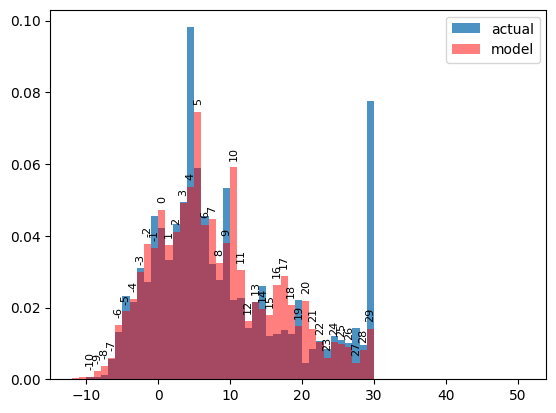

In [10]:
#for i in range(1,11, 2):
	#plot_model(38, 3, i)
plot_model(29,1)

In [11]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
	'air_yard_cols':x_cols
}
feature_config

update_config(feature_config)